# Bi-Input Model Training

In this notebook the basic model is trained on the normalized dataset.

In [1]:
from bi_input_model import BiInputModel

Load dataset

In [2]:
import torch

dataset_path = "data/main_dataset/base_open_walls/"

# load test input/output data
inputs = torch.load(dataset_path + "inputs.pt")
outputs = torch.load(dataset_path + "outputs.pt")

inputs.shape, outputs.shape

(torch.Size([896, 2, 21, 21]), torch.Size([896, 2, 21, 21]))

Normalize data

In [3]:
from data.normalization import normalize_data, denormalize_data

inputs, outputs = normalize_data(inputs, outputs, dataset_path + "min_max.yaml")


Inspect one input/output sample

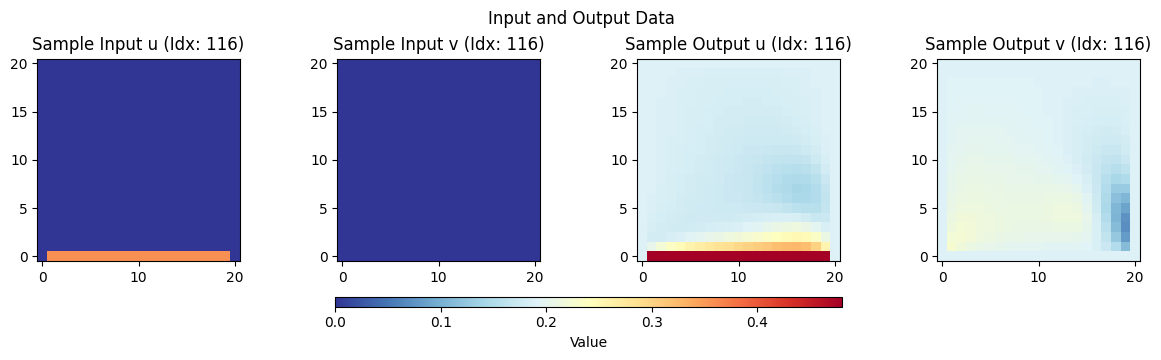

In [4]:
from plotting import plot_data_samples

plot_data_samples(inputs, outputs, title="Input and Output Data")


Create training, validation and test data splits

In [5]:
import torch

# random sorting of input-output pairs
perm = torch.randperm(len(inputs)) # generate random permutation indices
inputs = inputs[perm]
outputs = outputs[perm]

# split data points into train, validation and test sets
x_train, y_train = inputs[:int(0.8 * len(inputs))], outputs[:int(0.8 * len(outputs))] # 80% of data
x_val, y_val = inputs[int(0.8 * len(inputs)):int(0.9 * len(inputs))], outputs[int(0.8 * len(outputs)):int(0.9 * len(outputs))] # 10% of data
x_test, y_test = inputs[int(0.9 * len(inputs)):], outputs[int(0.9 * len(outputs)):] # 10% of data

We take the training and validation data points and create a loader with them to train the model

In [23]:
import torch

batch_size = 50

# create tensor dataset and dataloader
train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

val_dataset = torch.utils.data.TensorDataset(x_val, y_val)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

In [24]:
x_train.shape, y_train.shape

(torch.Size([716, 2, 21, 21]), torch.Size([716, 2, 21, 21]))

Instantiate and train the model with the data

In [26]:
model = BiInputModel()
model.fit(train_dataloader, val_dataloader, learning_rate=0.0005, epochs=4000)

----------
Epoch 0
Training loss: 0.015827666968107224
Validation loss: 0.01595192588865757
----------
----------
Epoch 50
Training loss: 0.00014759281475562602
Validation loss: 0.00016939859051490203
----------
----------
Epoch 100
Training loss: 4.14716632803902e-05
Validation loss: 4.064552558702417e-05
----------
----------
Epoch 150
Training loss: 2.3278593289433047e-05
Validation loss: 2.3384194719255902e-05
----------
----------
Epoch 200
Training loss: 2.5993525923695415e-05
Validation loss: 2.9129999347787816e-05
----------
----------
Epoch 250
Training loss: 2.5504477889626287e-05
Validation loss: 3.4181068258476444e-05
----------
----------
Epoch 300
Training loss: 8.470397006021813e-06
Validation loss: 8.341660304722609e-06
----------
----------
Epoch 350
Training loss: 8.230755156546365e-06
Validation loss: 1.128120175053482e-05
----------
----------
Epoch 400
Training loss: 1.1558027836144902e-05
Validation loss: 1.1306799024168868e-05
----------
----------
Epoch 450
Trai

Visualize error evolution

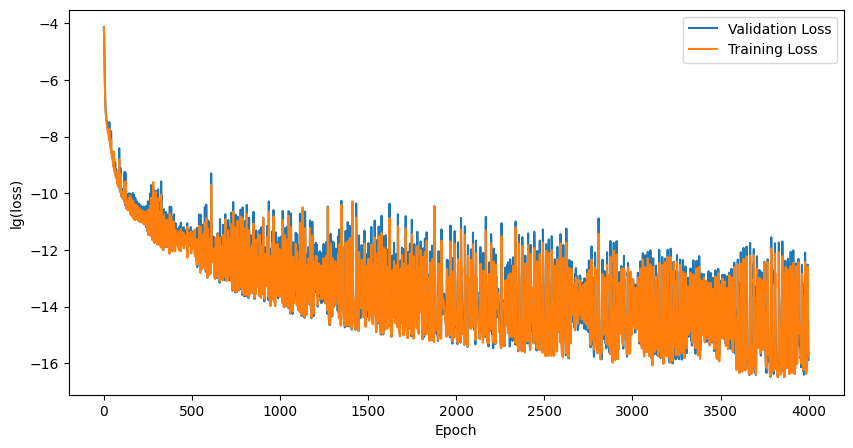

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# get the losses from the trained model
val_loss = model._validation_loss
train_loss = model._training_loss

# calculate the log of the losses
val_loss = np.log(val_loss)
train_loss = np.log(train_loss)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(val_loss, label="Validation Loss")
ax.plot(train_loss, label="Training Loss")
ax.set_xlabel("Epoch")
ax.set_ylabel("lg(loss)")
ax.legend()
plt.show()

Export model to save it

In [28]:
model.export_model(path="./models", name="bi_input_model_v2")

Reload the model

In [ ]:
model_test = BiInputModel()
model_test.load_model("./models", "bi_input_model_v2")

Check error size for the test set

In [29]:
# create data loader with test set
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    num_workers=0
)

mse = 0
mae = 0
for batch_x, batch_y in test_loader:
    y_predict = model_test.forward(batch_x.float()).detach()
    y = batch_y.detach()

    # calculate error for each batch
    mse += torch.mean((y_predict - y) ** 2)
    mae += torch.mean(torch.abs(y_predict - y))

rmse = torch.sqrt(mse)

print(f"Test RMSE: {rmse}")
print(f"Test MAE: {mae}")

    

Test RMSE: 0.0026922994293272495
Test MAE: 0.01910918951034546


Predict and visualize the results

In [16]:
y_predict = model_test.forward(x_test.float()).detach()
y_predict.shape

torch.Size([90, 2, 21, 21])

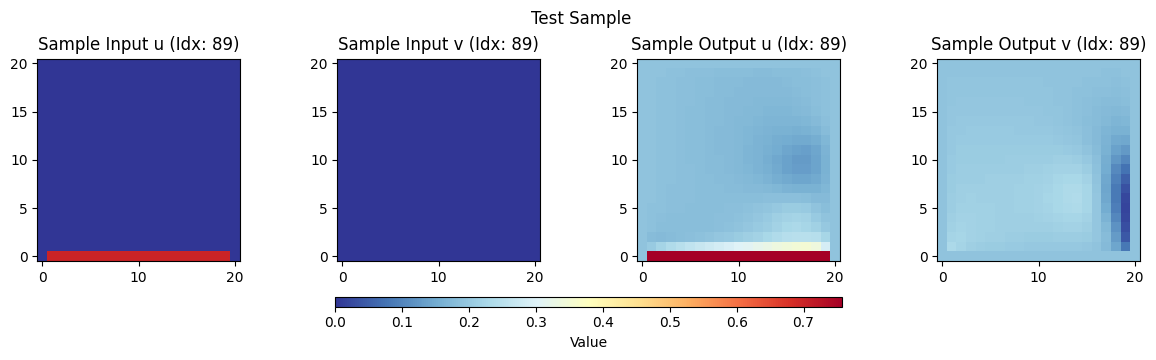

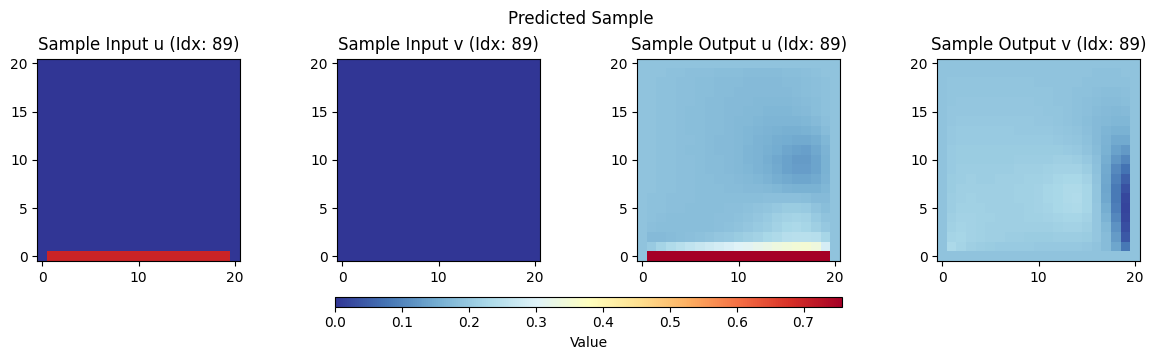

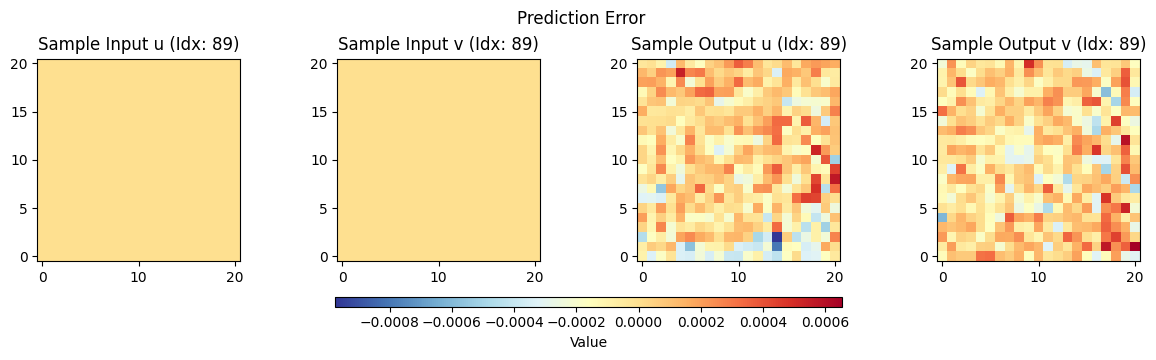

In [20]:
from plotting import plot_data_samples

idx = 89

plot_data_samples(x_test, y_test, "Test Sample", idx)
plot_data_samples(x_test, y_predict, "Predicted Sample", idx)
plot_data_samples(x_test - x_test, y_predict - y_test, "Prediction Error", idx)